In [1]:
import pandas as pd
from datetime import datetime,timedelta
%matplotlib inline

In [2]:
file = "../Datasets/Forecasting-US.csv"
df = pd.read_csv(file)
df

,day,cases,cases_new,growth,growth_percent,date
0,0,1,1,1.000000,0.000000,1/22/2020
1,1,1,0,1.000000,0.000000,1/23/2020
2,2,2,1,2.000000,100.000000,1/24/2020
3,3,2,0,1.000000,0.000000,1/25/2020
4,4,5,3,2.500000,150.000000,1/26/2020
...,...,...,...,...,...,...
68,68,161807,20921,1.148000,14.800000,3/30/2020
69,69,188172,26365,1.162000,16.200000,3/31/2020
70,70,213372,25200,1.133920,13.392003,4/1/2020
71,71,243453,30081,1.140979,14.097914,4/2/2020


In [3]:
d_100 = pd.to_datetime(df[df.cases >= 100]['date'].min())

In [4]:
Select_Country = 'US'
# records_start_date = d_100
records_start_date = datetime(2020, 1, 22)
print('Showing days since records started: ' + str(records_start_date.date()))

Showing days since records started: 2020-01-22


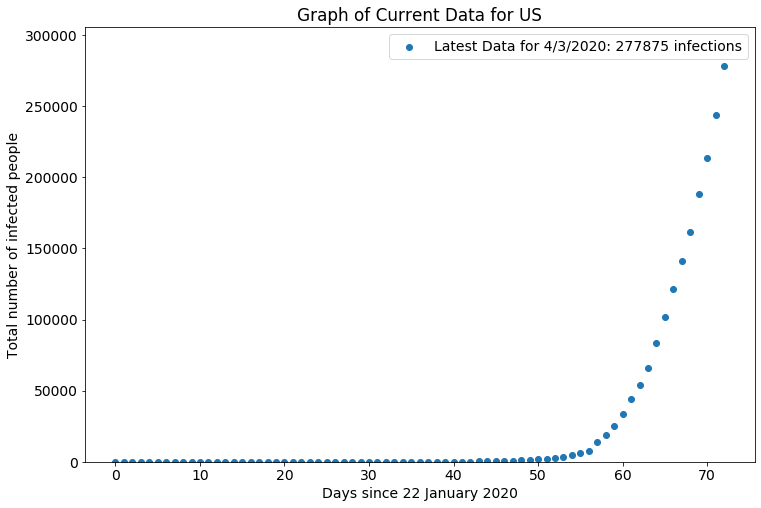

In [5]:
# Plot 1
#@title { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as curplt
curplt.rc('font', size=14)


def plot_current_data(df, label, color=None):
    x = df['day'].tolist()
    y = df['cases'].tolist()
    curplt.scatter(x, y, label="Latest Data for " + label, c=color)


def show_plot(curplt, title, y_max=None):
    curplt.title(title)
    curplt.xlabel("Days since 22 January 2020")
    curplt.ylabel("Total number of infected people")
    if (y_max):
        curplt.ylim(0, y_max * 1.1)
    curplt.legend()
    curplt.show()


# Plot
latest_cases = df['cases'].tolist()[-1]

curplt.figure(figsize=(12, 8))
dates = df['date'].tolist()
plot_current_data(df, str(dates[-1]) + ": "+ str(latest_cases) + " infections")

y_max = max(df['cases'])
show_plot(curplt, "Graph of Current Data for " + Select_Country, y_max)



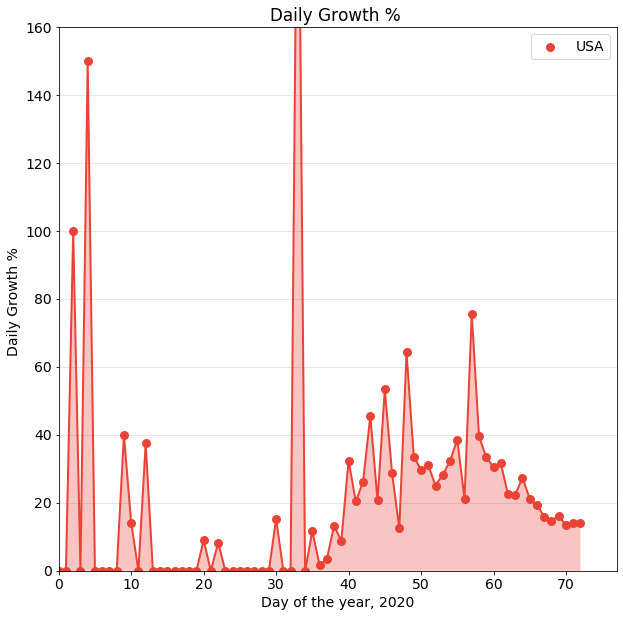

In [6]:
#@title { vertical-output: true, display-mode: "form" }
dfg = df.copy()
dfg2 = df.copy()
x = dfg2['day'].tolist()
y = dfg2['growth_percent'].tolist()

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.figure(figsize=(10, 10))
plt_axes = plt.gca()
plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="USA", linewidth=3)
plt.xlim(int(min(x)), int(max(x) + 5))
plt.ylim(0, 160)
plt.title("Daily Growth % ")
plt.xlabel("Day of the year, 2020")
plt.ylabel("Daily Growth % ")
plt.legend()
plt.show()

Make predictions by fitting the Logistic Growth curve.

The predictions becomes more reliable as the predictions for each day come closer to matching each other and the ± standard error gets lower. 

However where infections in a given location are still in the exponential phase the logistic growth curve fit is likely to significantly underestimate.


In [7]:
# Predictions
#@title { vertical-output: true, display-mode: "form" }
import numpy as np
import locale
from scipy.optimize import curve_fit, fsolve
from IPython.display import HTML as html_print
from datetime import timedelta

locale.setlocale(locale.LC_ALL, '')

def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))


# fit the data to the model (find the model variables that best approximate)
def predict_logistic_maximum(df):
    samples = df.shape[0]
    x_days = df['day'].tolist()
    y_cases = df['cases'].tolist()
    initial_guess = 4, 100, 25000 # speed, peak, amplitude

    fit = curve_fit(logistic_model, x_days, y_cases, p0=initial_guess, maxfev=9999)

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x day where the function reaches 99.99%
    end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples


# print results
def print_prediction(df, label):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    print(label + " prediction: " +
          "Maximum cases: " + comma_format(y_max) +
          " (± " + comma_format(y_max_error) + ")" +
          ". Peak at day: " + comma_format(x_peak) +
          " (± " + str(round(x_peak_error, 2)) + ")" +
          ", ending on day: " + str(end))
    return y_max, x_peak, end

def get_infected_for_day(df, xday):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df)
    num_infected = logistic_model(xday, speed, x_peak, y_max)
    return num_infected

def comma_format(rawnum):
    return f'{int(round(rawnum)):n}'

x_day_num = df['day'].tolist()

lookback_condition1 = len(x_day_num) > 30 and latest_cases > 1000
lookback_condition2 = len(x_day_num) > 50 and latest_cases > 5000

if lookback_condition2:
    print_prediction(df[:-10], "10 days ago's")

if lookback_condition1:
    print_prediction(df[:-5], "5 days ago's")

print_prediction(df[:-2], "2 days ago's")
print_prediction(df[:-1], "Yesterday's")
print()
pred, xpeak_day, end_day = print_prediction(df, "Today's")
print()
num_infected_for_today = get_infected_for_day(df, x_day_num[-1])
num_infected_for_tmrw = get_infected_for_day(df, x_day_num[-1] + 1)
new_infected_for_tmrw = round(num_infected_for_tmrw - num_infected_for_today)

num_infected_for_6days = get_infected_for_day(df, x_day_num[-1] + 6)
num_infected_for_7days = get_infected_for_day(df, x_day_num[-1] + 7)
new_infected_for_7days = round(num_infected_for_7days - num_infected_for_6days)

num_infected_for_13days = get_infected_for_day(df, x_day_num[-1] + 13)
num_infected_for_14days = get_infected_for_day(df, x_day_num[-1] + 14)
new_infected_for_14days = round(num_infected_for_14days - num_infected_for_13days)

infection_peak_date = records_start_date + timedelta(days=xpeak_day)
infection_max_date = records_start_date + timedelta(days=end_day)

current_cases_str = "<br />Current number of infections in <b>" + Select_Country + "</b> is: <b>" + comma_format(latest_cases) + "</b><br /><br />"
tomorrow_cases_str = "Expected number of new infections tomorrow:<b> " + comma_format(new_infected_for_tmrw) + "</b><br /><br />"
days7_cases_str = "Expected number of new infections 7 days from now:<b> " + comma_format(new_infected_for_7days) + "</b><br /><br />"
days14_cases_str = "Expected number of daily infections 14 days from now:<b> " + comma_format(new_infected_for_14days) + "</b><br /><br />"
peak_str = "Date of peak growth: <b>" + str(infection_peak_date.date()) + "</b><br /><br />"
end_str = "Date most new infections should stop: <b>" + str(infection_max_date.date()) + "</b><br /><br />"
total_infection_str = "The total infection in <b>" + Select_Country + "</b> should stabilize at: <b>" + comma_format(pred) + "</b><br /><br />"

html_print("<p>" + current_cases_str + tomorrow_cases_str + days7_cases_str +days14_cases_str + peak_str + end_str + total_infection_str + "</p>")

10 days ago's prediction: Maximum cases: 115,147 (± 6,375). Peak at day: 62 (± 0.27), ending on day: 80
5 days ago's prediction: Maximum cases: 252,626 (± 6,540). Peak at day: 66 (± 0.16), ending on day: 88
2 days ago's prediction: Maximum cases: 332,229 (± 7,223). Peak at day: 68 (± 0.16), ending on day: 92
Yesterday's prediction: Maximum cases: 376,753 (± 9,337). Peak at day: 69 (± 0.2), ending on day: 95

Today's prediction: Maximum cases: 437,975 (± 13,234). Peak at day: 70 (± 0.25), ending on day: 97



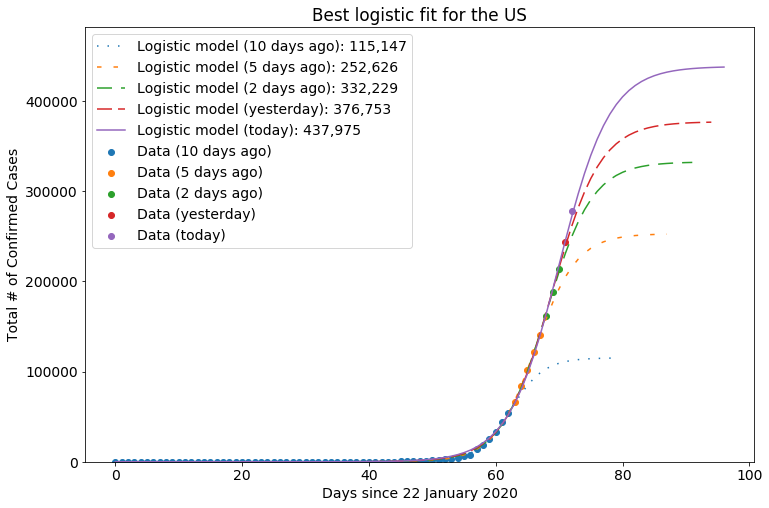

In [24]:
# Plot 2
#@title { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rc('font', size=14)


def add_real_data(df, label, color=None):
    x = df['day'].tolist()
    y = df['cases'].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)


def add_logistic_curve(df, label, **kwargs):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
             [logistic_model(i, speed, x_peak, y_max) for i in x_range],
             label="Logistic model (" + label + "): " + comma_format(y_max),
             **kwargs)
    return y_max


def label_and_show_plot(svg, plt, title, y_max=None):
    plt.title(title)
    plt.xlabel("Days since 22 January 2020")
    plt.ylabel("Total # of Confirmed Cases")
    if (y_max):
        plt.ylim(0, y_max * 1.1)
    plt.legend()
    plt.savefig(svg)
    plt.show()


# Plot
plt.figure(figsize=(12, 8))

add_real_data(df[:-10], "10 days ago")
add_real_data(df[-10:-5], "5 days ago")
add_real_data(df[-5:-2], "2 days ago")
add_real_data(df[-2:-1], "yesterday")
add_real_data(df[-1:], "today")

y_max_t_minus_c = 0
y_max_t_minus_d = 0
if lookback_condition2:
    y_max_t_minus_d = add_logistic_curve(df[:-10], "10 days ago", dashes=[1, 6])
if lookback_condition1:
    y_max_t_minus_c = add_logistic_curve(df[:-5], "5 days ago", dashes=[3, 8])

y_max_t_minus_b = add_logistic_curve(df[:-2], "2 days ago", dashes=[10, 6])
y_max_t_minus_a = add_logistic_curve(df[:-1], "yesterday", dashes=[10, 4])
y_max_t = add_logistic_curve(df, "today")
y_max = max([y_max_t, y_max_t_minus_a, y_max_t_minus_b, y_max_t_minus_c, y_max_t_minus_d])


label_and_show_plot('../static/image/logfitUS.svg', plt, "Best logistic fit for the " + Select_Country, y_max)

What changed since 2 days ago that steered the count up.
The growth "slowdown" stopped, staying for many days as a perfect exponential (1.25^x), lifting the amplitude of the Logistic fit.

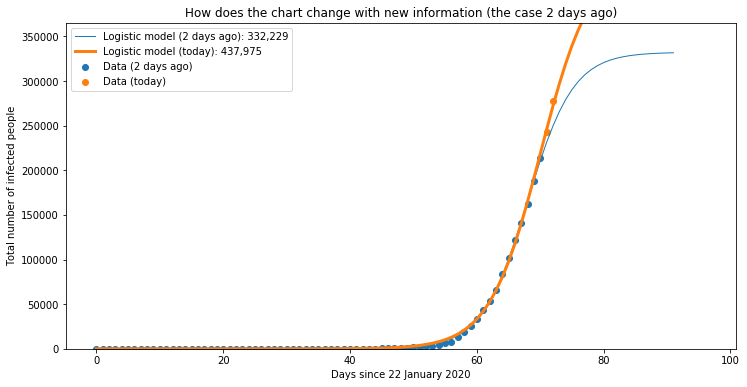

In [57]:
#@title { vertical-output: true, display-mode: "form" }
# Plot
plt.figure(figsize=(12, 6))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:], "today")
y_max = add_logistic_curve(df[:-2], "2 days ago", linewidth=1)
add_logistic_curve(df, "today", linewidth=3)
label_and_show_plot(plt, "How does the chart change with new information (the case 2 days ago)", y_max)

#### Experiment 1: discarding noisy initial samples
Try discarding points at the beginning days to see how it affects the prediction.

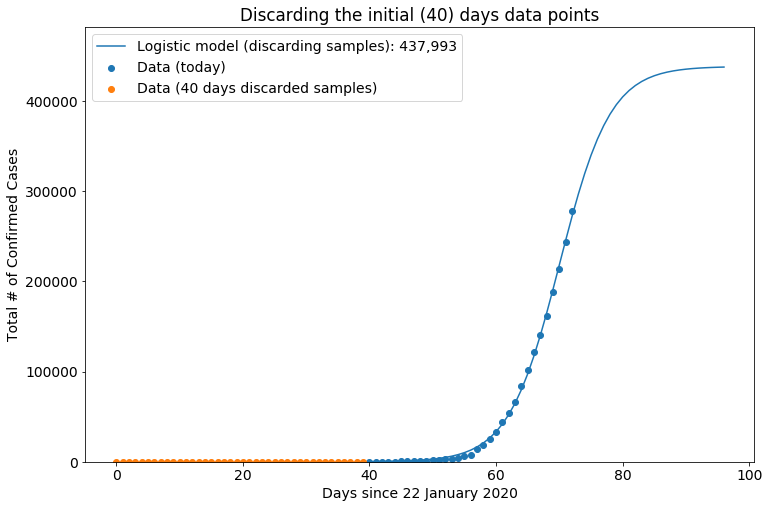

In [18]:
#@title Try it yourself { run: "auto", vertical-output: true, form-width: "620px", display-mode: "form" }
points_to_discard = 40 #@param {type:"slider", min:0, max:12, step:1}

# Plot: discard initial data points
plt.figure(figsize=(12, 8))
pts = points_to_discard
add_real_data(df[pts:], "today")
add_real_data(df[:pts], str(pts) + " days discarded samples")
y_max = add_logistic_curve(df[pts:], "discarding samples")
label_and_show_plot(plt, "Discarding the initial (" + str(pts) + ") days data points", y_max)

#### Hypothetical Scenario: What if cases decreased X percent a day for the next 5 days?
To test what would happen for the growth to decrease by between 0 and 2.5 percent per day, select a positive percentage. You can also increase the growth per day by selecting a negative percentage.

For perspective, China managed to decrease new cases by an average of just over 2% per day for about 7 days after the quarintine became effective, that likely represents a best case scenario.

Current infections: 277,875
Current growth rate: 1.141390741 (14.14%)
Using current mean growth rate (from the last 2 days): 1.141 (14.1%)



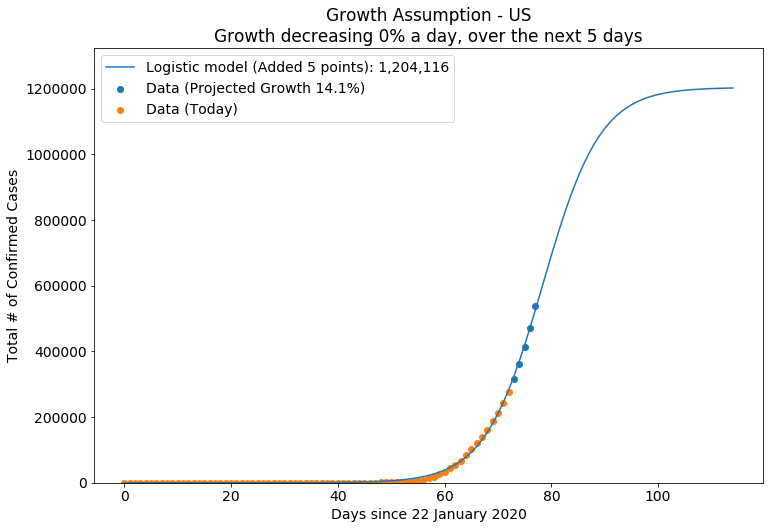



Hypothetical prediction: Maximum cases: 1,204,116 (± 86,523). Peak at day: 78 (± 0.68), ending on day: 115



In [30]:
# Plot 3
import statistics

growth = df['growth'].tolist()
last_growth = float(growth[-1])
last_mean_growth = round(statistics.mean(growth[-2:]),3)

print("Current infections: " + comma_format(latest_cases))
print("Current growth rate: " + str(last_growth) + " (" + str(round((last_growth-1)*100,2))+ "%)")
print("Using current mean growth rate (from the last 2 days): " + str(last_mean_growth) + " (" + str(round((last_mean_growth-1)*100,2))+ "%)")
print()
Percentage_Decrease = 0 #@param {type:"slider", min:-1, max:2.5, step:0.05}

d1 = last_mean_growth - (Percentage_Decrease/100)
d2 = last_mean_growth - ((Percentage_Decrease/100) * 2)
d3 = last_mean_growth - ((Percentage_Decrease/100) * 3)
d4 = last_mean_growth - ((Percentage_Decrease/100) * 4)
d5 = last_mean_growth - ((Percentage_Decrease/100) * 5)
# Add here to see extra days
#d6 = last_mean_growth - ((Percentage_Decrease/100) * 6)
#d7 = last_mean_growth - ((Percentage_Decrease/100) * 7)
#d8 = last_mean_growth - ((Percentage_Decrease/100) * 8)
#d9 = last_mean_growth - ((Percentage_Decrease/100) * 9)
#d10 = last_mean_growth - ((Percentage_Decrease/100) * 10)

add_points = [d1,d2,d3,d4,d5]#,d6,d7,d8,d9,d10]
num_points = len(add_points)
for i, s in enumerate(add_points):
    add_points[i] = round(s, 3)

df2 = df.copy()
df2 = df2.loc[:, ['day', 'cases']]

for a in add_points:
    df2 = df2.append(pd.Series([df2.iloc[-1][0] + 1, int(df2.iloc[-1][1] * a)], index=df2.columns), ignore_index=True)
plt.figure(figsize=(12, 8))
# growing_str = [str(round((d-1)*100,2))+ "%" for d in add_points]
growing_str = str(round((d1-1)*100,2))+ "%"
add_real_data(df2[-num_points:], "Projected Growth " + str(growing_str))
add_real_data(df2[:-num_points], "Today")
y_max = add_logistic_curve(df2, "Added " + str(len(add_points)) + " points")

increment_str = "Growth decreasing " + str(Percentage_Decrease)
if Percentage_Decrease < 0:
    increment_str = "Growth increasing " + str(Percentage_Decrease * -1)

label_and_show_plot('../static/image/projectionUS.svg', plt,"Growth Assumption - " + Select_Country + "\n" + increment_str + "% a day, over the next " +str(len(add_points)) + " days", y_max)

# Hypothetical future figures
print()
print()
hyp_pred, hyp_xpeak_day, hyp_end_day = print_prediction(df2, "Hypothetical")

print()


hyp_num_infected_for_today = get_infected_for_day(df2, x_day_num[-1])
hyp_num_infected_for_tmrw = get_infected_for_day(df2, x_day_num[-1] + 1)
hyp_new_infected_for_tmrw = round(hyp_num_infected_for_tmrw - hyp_num_infected_for_today)

hyp_num_infected_for_6days = get_infected_for_day(df2, x_day_num[-1] + 6)
hyp_num_infected_for_7days = get_infected_for_day(df2, x_day_num[-1] + 7)
hyp_new_infected_for_7days = round(hyp_num_infected_for_7days - hyp_num_infected_for_6days)

hyp_num_infected_for_13days = get_infected_for_day(df2, x_day_num[-1] + 13)
hyp_num_infected_for_14days = get_infected_for_day(df2, x_day_num[-1] + 14)
hyp_new_infected_for_14days = round(hyp_num_infected_for_14days - hyp_num_infected_for_13days)

hyp_infection_peak_date = records_start_date + timedelta(days=hyp_xpeak_day)
hyp_infection_max_date = records_start_date + timedelta(days=hyp_end_day)

hyp_tomorrow_cases_str = "Expected number of new infections tomorrow:<b> " + comma_format(hyp_new_infected_for_tmrw) + "</b><br /><br />"
hyp_days7_cases_str = "Expected number of daily infections 7 days from now:<b> " + comma_format(hyp_new_infected_for_7days) + "</b><br /><br />"
hyp_days14_cases_str = "Expected number of daily infections 14 days from now:<b> " + comma_format(hyp_new_infected_for_14days) + "</b><br /><br />"
hyp_peak_str = "Date of peak growth: <b>" + str(hyp_infection_peak_date.date()) + "</b><br /><br />"
hyp_end_str = "Date most new infections should stop: <b>" + str(hyp_infection_max_date.date()) + "</b><br /><br />"
hyp_total_infection_str = "The total infection in <b>" + Select_Country + "</b> should stabilize at: <b>" + comma_format(hyp_pred) + "</b><br /><br />"

html_print("<p>"+ hyp_tomorrow_cases_str + hyp_days7_cases_str + hyp_days14_cases_str + hyp_peak_str + hyp_end_str + hyp_total_infection_str + "</p>")

## Conclusions
Come back to see the result on live data. I'll update every day.

As of now is hard to make predictions since most countries are still in the purely exponential part of the growth curve.

The prediction becomes more accurate when the graph passes the inflection point i.e when the number of new cases each day stops increasing exponentially.